Importing libraries...
✓ Libraries imported
Using device: cpu

Loading data...
✓ Train: 11 samples
✓ Val: 2 samples
✓ Test: 3 samples

Identifying features by modality...

📊 Feature counts:
  Audio: 68 features
  Text: 0 features
  Video: 75 features
  Total: 143 features

🔗 Creating early fusion (concatenating all features)...

✓ Concatenated feature matrix:
  X_train shape: (11, 143)
  X_val shape: (2, 143)
  X_test shape: (3, 143)
✓ Features normalized
✓ Dataloaders created (batch_size=8)
✓ Early Fusion Model created

Model architecture:
EarlyFusionModel(
  (model): Sequential(
    (0): Linear(in_features=143, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False

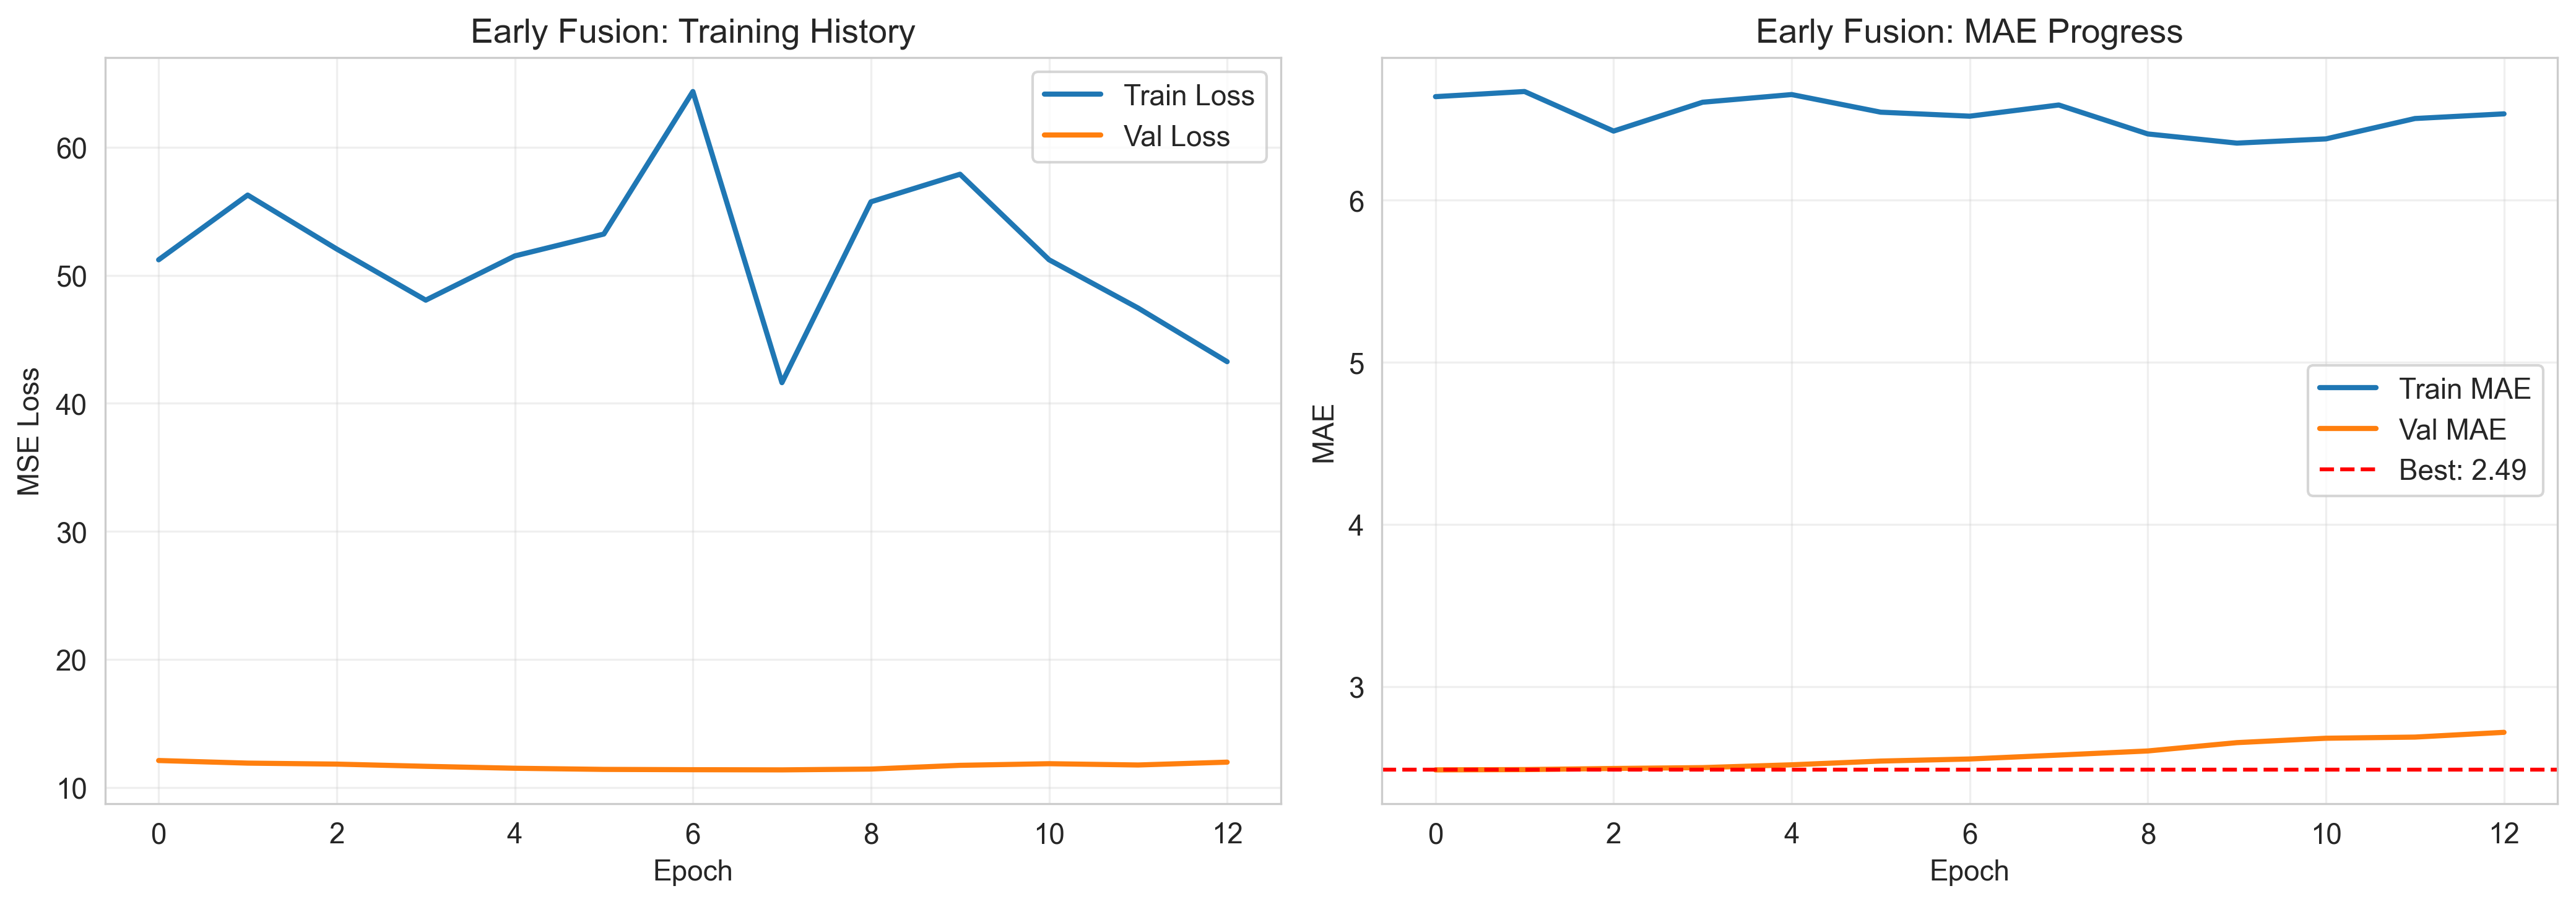


FINAL EVALUATION - EARLY FUSION

📊 Validation Set:
  MAE: 2.4858
  RMSE: 3.4773
  R²: -0.9346

📊 Test Set:
  MAE: 9.9444
  RMSE: 12.4559
  R²: -1.7705


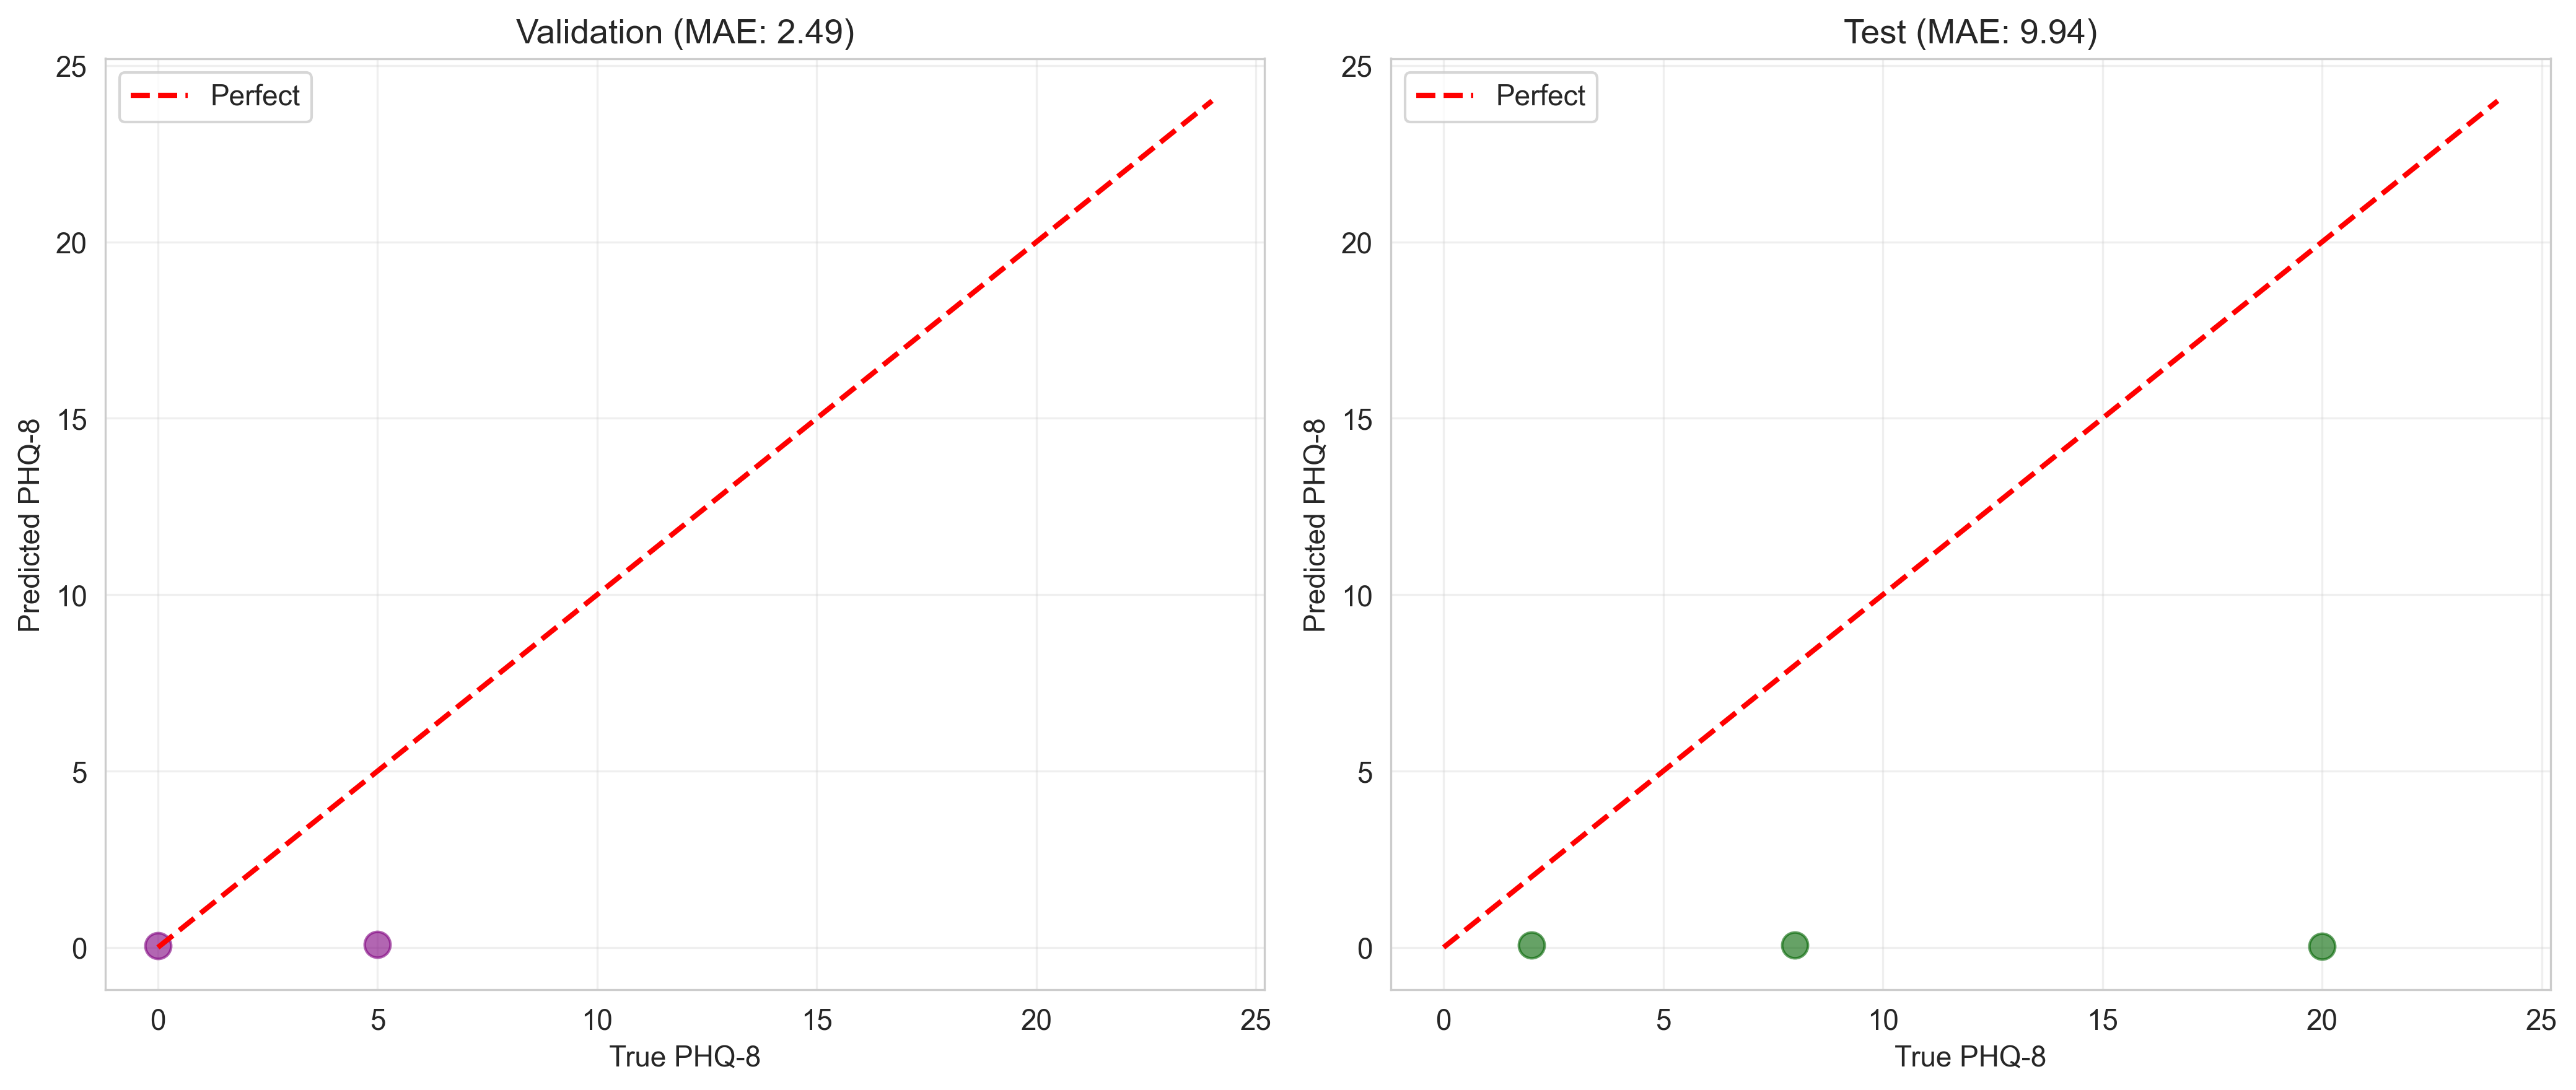


COMPARISON WITH BASELINES

📊 Test MAE Comparison:
  Audio-only: 9.9711
  Text-only: 9.7988
  Early Fusion (Audio+Text+Video): 9.9444

🎯 Improvement over best baseline: -1.5%
⚠ Early fusion did not beat baselines (may need tuning)

✓ Results saved: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\results\metrics\early_fusion_results.csv

✅ EARLY FUSION COMPLETE!

📊 Final Results:
  Test MAE: 9.9444
  Test R²: -1.7705
  Model: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\models\saved_models\early_fusion_best.pth

🎯 Next: Run Notebook 11 for Late Fusion (ensemble)


In [12]:
"""
NOTEBOOK 10: Early Fusion - Combining All Modalities

SAVE AS: notebooks/modeling/04_early_fusion.ipynb

WHAT THIS DOES:
- Concatenates audio + text + video features
- Trains ONE model on all features together
- Compares with single-modality baselines
- Target: Beat baseline performance

TIME: 20-30 minutes training
"""

# ========== CELL 1: Import Libraries ==========
print("Importing libraries...")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========== CELL 2: Load Data ==========

print("\nLoading data...")

PROCESSED_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\data\processed')
MODELS_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\models\saved_models')
RESULTS_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\results')

MODELS_DIR.mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / 'figures').mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / 'metrics').mkdir(parents=True, exist_ok=True)

# Load data
train_df = pd.read_csv(PROCESSED_DIR / 'train_data.csv')
val_df = pd.read_csv(PROCESSED_DIR / 'val_data.csv')
test_df = pd.read_csv(PROCESSED_DIR / 'test_data.csv')

print(f"✓ Train: {len(train_df)} samples")
print(f"✓ Val: {len(val_df)} samples")
print(f"✓ Test: {len(test_df)} samples")

# ========== CELL 3: Separate Features by Modality ==========

print("\nIdentifying features by modality...")

# Audio features
audio_cols = [col for col in train_df.columns if any(x in col for x in 
              ['mfcc', 'pitch', 'energy', 'spectral', 'zcr', 'rolloff', 'duration'])]

# Text features
text_cols = [col for col in train_df.columns if 'bert' in col.lower() or 
             any(x in col.lower() for x in ['word', 'positive', 'negative', 'question', 'sentiment', 'exclamation'])]

# Video features
video_cols = [col for col in train_df.columns if 'AU' in col or 'gaze' in col.lower() or 
              any(x in col for x in ['Tx', 'Ty', 'Tz', 'Rx', 'Ry', 'Rz', 'confidence', 'frame'])]

print(f"\n📊 Feature counts:")
print(f"  Audio: {len(audio_cols)} features")
print(f"  Text: {len(text_cols)} features")
print(f"  Video: {len(video_cols)} features")
print(f"  Total: {len(audio_cols) + len(text_cols) + len(video_cols)} features")

# ========== CELL 4: Create Concatenated Features (Early Fusion) ==========

print("\n🔗 Creating early fusion (concatenating all features)...")

# Concatenate all feature columns
all_feature_cols = audio_cols + text_cols + video_cols

# Extract features and labels
X_train = train_df[all_feature_cols].values
y_train = train_df['PHQ8_Score'].values

X_val = val_df[all_feature_cols].values
y_val = val_df['PHQ8_Score'].values

X_test = test_df[all_feature_cols].values
y_test = test_df['PHQ8_Score'].values

print(f"\n✓ Concatenated feature matrix:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_val shape: {X_val.shape}")
print(f"  X_test shape: {X_test.shape}")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"✓ Features normalized")

# ========== CELL 5: Create PyTorch Dataset ==========

class MultimodalDataset(Dataset):
    """Dataset for multimodal fusion"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = MultimodalDataset(X_train, y_train)
val_dataset = MultimodalDataset(X_val, y_val)
test_dataset = MultimodalDataset(X_test, y_test)

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ Dataloaders created (batch_size={batch_size})")

# ========== CELL 6: Define Early Fusion Model ==========

class EarlyFusionModel(nn.Module):
    """
    Early Fusion: All features concatenated, then passed through deep network
    
    Architecture:
    - Input: All features (audio + text + video)
    - Hidden layers with BatchNorm and Dropout
    - Output: PHQ-8 score
    """
    
    def __init__(self, input_size, hidden_sizes=[512, 256, 128, 64], dropout=0.3):
        super(EarlyFusionModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Build hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x).squeeze()

# Create model
input_size = X_train.shape[1]
model = EarlyFusionModel(
    input_size=input_size,
    hidden_sizes=[512, 256, 128, 64],
    dropout=0.3
)
model = model.to(device)

print(f"✓ Early Fusion Model created")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# ========== CELL 7: Training Setup ==========

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Remove verbose argument for compatibility
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)

print("✓ Training setup complete")
print(f"  Loss: MSE")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Scheduler: ReduceLROnPlateau")

# ========== CELL 8: Training Functions ==========

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend(outputs.detach().cpu().numpy())
        targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    mae = mean_absolute_error(targets, predictions)
    
    return avg_loss, mae

def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    r2 = r2_score(targets, predictions)
    
    return avg_loss, mae, rmse, r2, predictions, targets

print("✓ Training functions defined")

# ========== CELL 9: Train Model ==========

print("\n" + "="*60)
print("TRAINING EARLY FUSION MODEL")
print("="*60)
print("\n🔗 Combining Audio + Text + Video features")
print("This may take 20-30 minutes...\n")

num_epochs = 60
best_val_mae = float('inf')
patience = 12
patience_counter = 0

train_losses = []
val_losses = []
train_maes = []
val_maes = []

for epoch in range(num_epochs):
    # Train
    train_loss, train_mae = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_mae, val_rmse, val_r2, _, _ = evaluate(model, val_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, MAE: {train_mae:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
    
    # Save best model
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), MODELS_DIR / 'early_fusion_best.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\n✓ Training complete!")
print(f"Best validation MAE: {best_val_mae:.4f}")

# ========== CELL 10: Plot Training History ==========

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Early Fusion: Training History')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(train_maes, label='Train MAE', linewidth=2)
axes[1].plot(val_maes, label='Val MAE', linewidth=2)
axes[1].axhline(y=best_val_mae, color='r', linestyle='--', label=f'Best: {best_val_mae:.2f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Early Fusion: MAE Progress')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'early_fusion_training.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== CELL 11: Final Evaluation ==========

print("\n" + "="*60)
print("FINAL EVALUATION - EARLY FUSION")
print("="*60)

# Load best model
model.load_state_dict(torch.load(MODELS_DIR / 'early_fusion_best.pth'))

# Evaluate
val_loss, val_mae, val_rmse, val_r2, val_preds, val_targets = evaluate(model, val_loader, criterion, device)
test_loss, test_mae, test_rmse, test_r2, test_preds, test_targets = evaluate(model, test_loader, criterion, device)

print(f"\n📊 Validation Set:")
print(f"  MAE: {val_mae:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  R²: {val_r2:.4f}")

print(f"\n📊 Test Set:")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²: {test_r2:.4f}")

# ========== CELL 12: Visualize Predictions ==========

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Validation
axes[0].scatter(val_targets, val_preds, alpha=0.6, s=100, color='purple')
axes[0].plot([0, 24], [0, 24], 'r--', linewidth=2, label='Perfect')
axes[0].set_xlabel('True PHQ-8')
axes[0].set_ylabel('Predicted PHQ-8')
axes[0].set_title(f'Validation (MAE: {val_mae:.2f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test
axes[1].scatter(test_targets, test_preds, alpha=0.6, s=100, color='darkgreen')
axes[1].plot([0, 24], [0, 24], 'r--', linewidth=2, label='Perfect')
axes[1].set_xlabel('True PHQ-8')
axes[1].set_ylabel('Predicted PHQ-8')
axes[1].set_title(f'Test (MAE: {test_mae:.2f})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'early_fusion_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== CELL 13: Compare with Baselines ==========

print("\n" + "="*60)
print("COMPARISON WITH BASELINES")
print("="*60)

# Load baseline results
try:
    audio_results = pd.read_csv(RESULTS_DIR / 'metrics' / 'audio_lstm_results.csv')
    text_results = pd.read_csv(RESULTS_DIR / 'metrics' / 'text_bert_results.csv')
    
    # Handle different column names
    def get_test_mae(df):
        if 'test_mae' in df.columns:
            return df['test_mae'].values[0]
        elif 'Test_MAE' in df.columns:
            return df['Test_MAE'].values[0]
        elif 'MAE' in df.columns:
            # If Split column exists, pick test row
            if 'Split' in df.columns:
                test_row = df[df['Split'].str.lower()=='test']
                if len(test_row) > 0:
                    return test_row.iloc[0]['MAE']
                else:
                    return df.iloc[0]['MAE']
            else:
                return df.iloc[1]['MAE'] if len(df) > 1 else df.iloc[0]['MAE']
        else:
            raise KeyError("No suitable MAE column found in baseline CSV.")
    
    audio_mae = get_test_mae(audio_results)
    text_mae = get_test_mae(text_results)
    
    print("\n📊 Test MAE Comparison:")
    print(f"  Audio-only: {audio_mae:.4f}")
    print(f"  Text-only: {text_mae:.4f}")
    print(f"  Early Fusion (Audio+Text+Video): {test_mae:.4f}")
    
    # Calculate improvement
    best_baseline = min(audio_mae, text_mae)
    improvement = ((best_baseline - test_mae) / best_baseline) * 100
    
    print(f"\n🎯 Improvement over best baseline: {improvement:.1f}%")
    
    if test_mae < best_baseline:
        print("✅ Early fusion BEATS single modality baselines!")
    else:
        print("⚠ Early fusion did not beat baselines (may need tuning)")
        
except FileNotFoundError:
    print("\n⚠ Baseline results not found. Run baseline notebooks first!")
except KeyError as e:
    print(f"\n⚠ Column issue: {e}")

# ========== CELL 14: Save Results ==========

# Save results
results = {
    'model': 'Early Fusion',
    'modalities': 'audio+text+video',
    'num_features': input_size,
    'val_mae': val_mae,
    'val_rmse': val_rmse,
    'val_r2': val_r2,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2
}

results_df = pd.DataFrame([results])
results_df.to_csv(RESULTS_DIR / 'metrics' / 'early_fusion_results.csv', index=False)

print(f"\n✓ Results saved: {RESULTS_DIR / 'metrics' / 'early_fusion_results.csv'}")

# ========== CELL 15: Summary ==========

print("\n" + "="*60)
print("✅ EARLY FUSION COMPLETE!")
print("="*60)

print(f"\n📊 Final Results:")
print(f"  Test MAE: {test_mae:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Model: {MODELS_DIR / 'early_fusion_best.pth'}")

print(f"\n🎯 Next: Run Notebook 11 for Late Fusion (ensemble)")
print("="*60)

In [3]:
import os

# Look for any CSV file that may contain audio LSTM metrics
for root, _, files in os.walk("results"):
    for f in files:
        if "audio" in f.lower() and f.endswith(".csv"):
            print(os.path.join(root, f))
